In [40]:
# !pip install numpy matplotlib pandas tqdm

In [41]:
import json

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [42]:
with open("metrics.json", encoding="utf-8") as f:
    metrics = json.load(f)

In [43]:
pd.set_option('display.max_rows', 100)

float_tests = [{"size": v["size"],**v["tests"][0]} for v in metrics if v["type"] == "float" and "size" in v]
float_tests_df = pd.DataFrame(float_tests)
float_tests_df = float_tests_df.sort_values("duration", ascending=True)

double_tests = [{"size": v["size"],**v["tests"][0]} for v in metrics if v["type"] == "double" and "size" in v]
double_tests_df = pd.DataFrame(double_tests)
double_tests_df = double_tests_df.sort_values("duration", ascending=True)

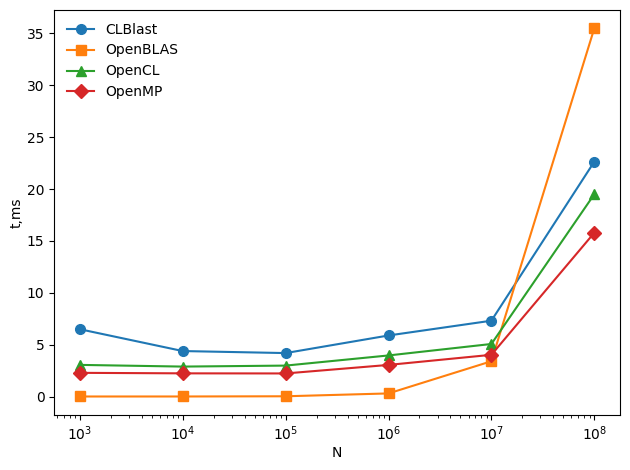

In [50]:

markers = ['o', 's', '^', 'D']

float_tests_df = float_tests_df[float_tests_df["runtime"] != "C++"]
float_tests_df = float_tests_df[float_tests_df["runtime"] != "C++*"]
items = float_tests_df.groupby("runtime")


for i, (runtime, group) in enumerate(items):
    group = group.groupby('size', as_index=False).mean(numeric_only=True)
    group = group[group["size"] >= 10**3]
    
    plt.plot(group["size"],
             group["duration"],
             marker=markers[i % len(markers)],
             markersize=7,
             label=runtime)

plt.ticklabel_format(axis='x', style='sci', scilimits=(0, 0)) 
plt.xscale('log')
plt.xlabel("N", labelpad=2)
plt.ylabel("t,ms", labelpad=2)
plt.legend()

plt.legend(fontsize=10, loc='best', frameon=False)
plt.tight_layout()
plt.show()
